In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dummy-advertising-and-sales-data/Dummy Data HSS.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

In [3]:
data = pd.read_csv( "/kaggle/input/dummy-advertising-and-sales-data/Dummy Data HSS.csv"  )
data.head()

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


In [4]:
X = data.drop(columns=["Sales"])
y = data["Sales"]
X.shape, y.shape

((4572, 4), (4572,))

In [5]:
X.isna().sum()

TV              10
Radio            4
Social Media     6
Influencer       0
dtype: int64

In [ ]:
y.isna().sum()

In [6]:
# Identify numerical and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

# Mean imputation to numerical columns
for col in numeric_features:
    X[col] = X[col].fillna(X[col].mean())
y = y.fillna(y.mean())

In [7]:
X.isna().sum()

TV              0
Radio           0
Social Media    0
Influencer      0
dtype: int64

In [ ]:
y.isna().sum()

## Standardize numeric features

We standardize only numerical columns using:
(x − mean) / standard deviation

Categorical features I'm keeping unchanged at this stage.

In [8]:
X_scaled = X.copy()
X_mean = X[numeric_features].mean()
X_std = X[numeric_features].std()

# Avoiding division by zero
X_std = X_std.replace(0, 1)

# Applying standardization
X_scaled[numeric_features] = (X[numeric_features] - X_mean) / X_std

y_mean = y.mean()
y_std = y.std()
if y_std == 0:
    y_std = 1
y_scaled = (y - y_mean) / y_std

In [9]:
X_encoded = pd.get_dummies(X_scaled, columns=categorical_features)
X_encoded.head()

,TV,Radio,Social Media,Influencer_Macro,Influencer_Mega,Influencer_Micro,Influencer_Nano
0,-1.458698,-1.198641,-0.188120,False,True,False,False
1,-1.573656,-0.922449,-0.413523,False,True,False,False
2,-0.500714,-0.235085,-0.185665,False,True,False,False
3,1.108700,1.226094,1.627315,False,True,False,False
4,-1.497017,-1.005192,-0.867376,False,False,True,False


In [10]:
# Verify original categories
X["Influencer"].value_counts()

Influencer
Mega     1158
Micro    1153
Nano     1139
Macro    1122
Name: count, dtype: int64

## Train–test split

I splitted the processed feature matrix and target vector into training and testing sets using an 80–20 ratio.


In [11]:
m = len(X_encoded)

# Generating shuffled indices
indices = np.random.permutation(m)

# 80-20 splitting
train_size = int(0.8 * m)

train_idx = indices[:train_size]
test_idx = indices[train_size:]

# Creating train and test sets
X_train = X_encoded.iloc[train_idx]
X_test  = X_encoded.iloc[test_idx]

y_train = y_scaled.iloc[train_idx]
y_test  = y_scaled.iloc[test_idx]

X_train.shape, X_test.shape

((3657, 7), (915, 7))

### Linear Regression class (skeleton)

We define a class to store:
- learning rate
- number of epochs
- batch size
- model parameters (weights and bias)

No training logic is added yet.


In [12]:
class LinearRegression:
    
    def __init__(self, learning_rate=0.01, epochs=500, batch_size=32):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
        # Model parameters (to be learned, currently Null)
        self.weights = None
        self.bias = None
        
        # Store loss values
        self.loss_history = []

    def fit(self, X, y):  #  fit() method – initialization and data preparation
        X = X.values
        y = y.values
        
        m, n = X.shape
        
        # Initialize weights and bias
        self.weights = np.zeros(n)
        self.bias = 0.0

        # Loop over epochs
        for epoch in range(self.epochs):     # This is the outer training loop over epochs.
            
            # Shuffle data at the start of each epoch
            indices = np.random.permutation(m)   # To make gradient descent stochastic, we shuffle the training data at the beginning of every epoch.
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Loop over mini-batches
            for start_idx in range(0, m, self.batch_size):   # After shuffling the data in each epoch, we split it into mini-batches of size `batch_size`.
                end_idx = start_idx + self.batch_size
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]  
                
                # Forward pass: compute predictions
                y_pred = np.dot(X_batch, self.weights) + self.bias    # For each mini-batch, computing the predicted output using the linear regression model: ŷ = X · w + b
                
                # Compute Mean Squared Error loss for the mini-batch
                batch_size_actual = len(y_batch)
                loss = (1 / (2 * batch_size_actual)) * np.sum((y_batch - y_pred) ** 2)  # Computing the Mean Squared Error (MSE) loss for the current mini-batch.
                
                # Compute gradients w.r.t. weights and bias
                dw = (-1 / batch_size_actual) * np.dot(X_batch.T, (y_batch - y_pred))
                db = (-1 / batch_size_actual) * np.sum(y_batch - y_pred)   # Computing the gradients of the Mean Squared Error loss with respect to the model parameters (weights and bias).
                
                # Update weights and bias using gradient descent
                self.weights = self.weights - self.learning_rate * dw
                self.bias = self.bias - self.learning_rate * db  #  Updating the model parameters using gradient descent.
                
                # Store loss
                self.loss_history.append(loss)

    def predict(self, X):  # The predict method generates predictions for new input data using the learned weights and bias.

        # Convert pandas DataFrame to NumPy array
        X = X.values
        
        # Compute predictions using learned parameters
        y_pred = np.dot(X, self.weights) + self.bias
        
        return y_pred

| Component | Equation           |
| --------- | ------------------ |
| Loss      |(1 / 2m) Σ (y − ŷ)² |
| dw        | -1/m · Xᵀ(y − ŷ)   |
| db        |-1/m · Σ(y − ŷ)     |

In [13]:
# Create model instance
model = LinearRegression(
    learning_rate=0.01,
    epochs=500,
    batch_size=32
)

# Train the model
model.fit(X_train, y_train)

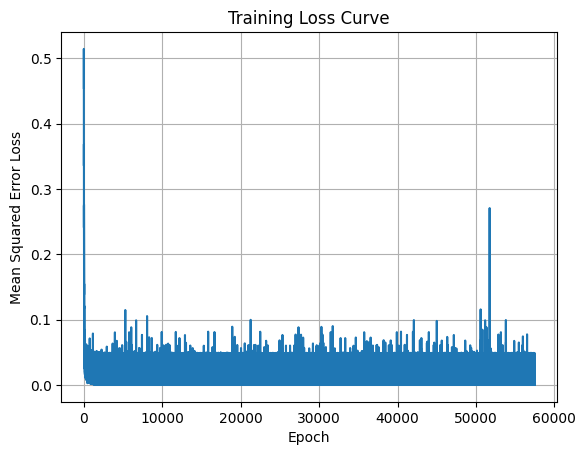

In [15]:
plt.plot(model.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [16]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = np.mean((y_train - y_train_pred) ** 2)
test_mse = np.mean((y_test - y_test_pred) ** 2)

train_mse, test_mse


(np.float64(0.007401741515525753), np.float64(0.003573395653421297))